# This notebook will use GEE using packages geemap, ee, and scikit-learn to train a regression model

### The study area is a city in Pakistan called Charsadda which is in the norhtern part of the country. It is chosen because it has a variation of elevation and greenary in its surroundings.

### Initialize GEE

In [2]:
import ee
import geemap

In [3]:
# # If you are running this notebook for the first time, you need to activate the command below for the authentication flow:
# ee.Authenticate()

In [4]:
try:
    # Initialize the library.
    ee.Initialize()
    print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
    print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

Google Earth Engine has initialized successfully!


### Define study area and dates

In [5]:
# A point over Charsadda, Pakistan
point = ee.Geometry.Point([71.755005, 34.16239])

# Create a buffer which will be used as the AOI, 40kn
aoi = point.buffer(40000)

# Define the start and end dates
start_date = '2020-01-01'
end_date = '2020-12-31'

In [6]:
# Initialize the map
Map = geemap.Map()

In [7]:
# Visualize the Map centered over the area
Map.centerObject(aoi, 9)
Map.addLayer(aoi, {'color': 'blue'}, 'Area of Interest (AOI)')
Map

Map(center=[34.162431034485216, 71.7550063752409], controls=(WidgetControl(options=['position', 'transparent_b…

### Calculate NDVI and generate monthly composites

In [8]:
# Function to calculate NDVI from input bands, also clips the images to the AOI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi.clip(aoi))


In [9]:
# Select the images from GEE using the input location and dates, we dont use cloud filter, because it restricts the number of images which is too small
image_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                      .filterBounds(aoi) \
                      .filter(ee.Filter.contains('.geo', aoi))\
                      .filterDate(start_date, end_date) \
                      .map(calculate_ndvi)\
                      # .filter(ee.Filter.lt('CLOUD_COVER', 10))
                      

In [10]:
# Calculate the number of images per month, so we can see if we miss any months
monthly_counts = {
    f'Month {month:02d}': image_collection.filter(ee.Filter.calendarRange(month, month, 'month')).size().getInfo()
    for month in range(1, 13)
}

# Print the monthly counts
print("Monthly image counts:", monthly_counts)

# Print total number of images
print (f'Total Images: {image_collection.size().getInfo()}')

Monthly image counts: {'Month 01': 1, 'Month 02': 0, 'Month 03': 1, 'Month 04': 1, 'Month 05': 2, 'Month 06': 2, 'Month 07': 2, 'Month 08': 2, 'Month 09': 2, 'Month 10': 2, 'Month 11': 2, 'Month 12': 2}
Total Images: 19


In [11]:
# Function to calculate monthly mean from all images
def monthly_median_ndvi(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    
    # Filter images in the given month and calculate the median NDVI
    monthly_ndvi = image_collection.filterDate(start, end).select('NDVI').median()
    
    return monthly_ndvi.set('system:time_start', start.millis())

In [12]:
# Generate monthly composites
monthly_ndvi_composites = ee.ImageCollection([monthly_median_ndvi(2020, month) for month in range(1, 13)])
monthly_ndvi_composites

In [13]:
# Visualize the monthyl NDVIs on map
ndvi_vis_params = {
    'min': 0.0,
    'max': 1.0,
    'palette': ['blue', 'white', 'green']
}

# Add each monthly NDVI composite to the map
for month in range(1, 13):
    ndvi_image = monthly_ndvi_composites.filter(ee.Filter.calendarRange(month, month, 'month')).first()
    Map.addLayer(ndvi_image, ndvi_vis_params, f'Month {month} - NDVI Median Composite')
    
Map

Map(bottom=52588.0, center=[34.162431034485216, 71.7550063752409], controls=(WidgetControl(options=['position'…

### Get the elevation and precipitation datasets

In [14]:
# Select the elevation dataset
elevation = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(aoi)

Map.addLayer(elevation, {min: 10, max: 200}, 'Elevation')

In [15]:
# Select the precipitation filtered by the dates
precipitation = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')\
                .filterBounds(aoi)\
                .filterDate(start_date, end_date)\
                .map(lambda image: image.clip(aoi))

In [16]:
# Compute monthly precipitation from the dataset
def monthly_precipitation(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    
    # Filter images within the month and sum the daily precipitation
    monthly_precip = precipitation.filterDate(start, end).sum().rename('monthly_precipitation')
    return monthly_precip.set('system:time_start', start.millis())

In [17]:
# Generate monthly precipitation composites
monthly_precipitation_composites = ee.ImageCollection([monthly_precipitation(2020, month) for month in range(1, 13)])

In [18]:
# Add the precipitation data on the map
precip_vis_params = {
    'min': 0.0,
    'max': 300.0, 
    'palette': ['blue', 'cyan', 'yellow', 'orange', 'red']
}

# Add each monthly precipitation layer to the map
for month in range(1, 13):
    precip_image = monthly_precipitation_composites.filter(ee.Filter.calendarRange(month, month, 'month')).first()
    Map.addLayer(precip_image, precip_vis_params, f'Month {month} - Precipitation')

Map

Map(bottom=52588.0, center=[34.162431034485216, 71.7550063752409], controls=(WidgetControl(options=['position'…

### Prepare dataset for sampling and modelling

In [19]:
# Stack all the images (composites) to one image as bands
stacked_images = monthly_precipitation_composites.toBands().addBands(elevation.rename('elevation')).addBands(monthly_ndvi_composites.toBands())

In [20]:
# Check if all bands have been included
stacked_images.bandNames().getInfo()

['0_monthly_precipitation',
 '1_monthly_precipitation',
 '2_monthly_precipitation',
 '3_monthly_precipitation',
 '4_monthly_precipitation',
 '5_monthly_precipitation',
 '6_monthly_precipitation',
 '7_monthly_precipitation',
 '8_monthly_precipitation',
 '9_monthly_precipitation',
 '10_monthly_precipitation',
 '11_monthly_precipitation',
 'elevation',
 '0_NDVI',
 '2_NDVI',
 '3_NDVI',
 '4_NDVI',
 '5_NDVI',
 '6_NDVI',
 '7_NDVI',
 '8_NDVI',
 '9_NDVI',
 '10_NDVI',
 '11_NDVI']

In [21]:
# Remove the band called '1_monthly_precipitation' because we dont have NDVI for that month as well
stacked_images = stacked_images.select([band for band in stacked_images.bandNames().getInfo() if band != '1_monthly_precipitation'])

In [22]:
# Generate training samples
training = stacked_images.sample(
    **{
        'region': aoi,
        "scale": 30,
        "numPixels": 1000,
        "seed": 0,
        "geometries": True,  # Set this to False to ignore geometries
    }
)

Map.addLayer(training, {}, "training", False)
Map

Map(bottom=52588.0, center=[34.162431034485216, 71.7550063752409], controls=(WidgetControl(options=['position'…

In [23]:
training.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [71.87884871250766, 34.201707805736575]},
 'id': '0',
 'properties': {'0_NDVI': 0.08072718977928162,
  '0_monthly_precipitation': 82.7678632736206,
  '10_NDVI': 0.2471209317445755,
  '10_monthly_precipitation': 34.226433753967285,
  '11_NDVI': 0.14170488715171814,
  '11_monthly_precipitation': 24.456089973449707,
  '2_NDVI': 0.274370014667511,
  '2_monthly_precipitation': 153.23280811309814,
  '3_NDVI': 0.43302974104881287,
  '3_monthly_precipitation': 183.04231548309326,
  '4_NDVI': 0.2742333710193634,
  '4_monthly_precipitation': 56.226464410312474,
  '5_NDVI': 0.2290506809949875,
  '5_monthly_precipitation': 12.706579141131726,
  '6_NDVI': 0.29161474108695984,
  '6_monthly_precipitation': 16.47406244277954,
  '7_NDVI': 0.4130811393260956,
  '7_monthly_precipitation': 43.281362533569336,
  '8_NDVI': 0.38301995396614075,
  '8_monthly_precipitation': 52.18889379501343,
  '9_NDVI': 0.3100825250148773,
  '9_monthly_preci

### Working with pandas

In [24]:
# Convert the training samples to a pandas dataframe
import pandas as pd

In [25]:
df = geemap.ee_to_df(training)

In [26]:
df

,0_monthly_precipitation,2_monthly_precipitation,3_monthly_precipitation,4_monthly_precipitation,5_monthly_precipitation,6_monthly_precipitation,7_monthly_precipitation,8_monthly_precipitation,9_monthly_precipitation,10_monthly_precipitation,...,2_NDVI,3_NDVI,4_NDVI,5_NDVI,6_NDVI,7_NDVI,8_NDVI,9_NDVI,10_NDVI,11_NDVI
0,82.767863,153.232808,183.042315,56.226464,12.706579,16.474062,43.281363,52.188894,6.009055,34.226434,...,0.274370,0.433030,0.274233,0.229051,0.291615,0.413081,0.383020,0.310083,0.247121,0.141705
1,70.541698,159.853855,216.754616,54.612937,11.298970,13.946606,16.746099,9.861984,8.803895,36.078949,...,0.170612,0.187555,0.100143,0.074050,0.063712,0.059243,0.067316,0.068260,0.094112,0.133866
2,68.638449,162.330604,165.300001,52.108443,11.641338,11.806854,31.321755,20.358425,7.461596,32.678040,...,0.098798,0.141298,0.143953,0.131339,0.119275,0.120170,0.132944,0.115921,0.093896,0.074901
3,44.584864,156.883410,123.226017,36.267673,14.957363,19.654797,60.585711,37.927055,4.824198,35.315495,...,0.336234,0.314513,0.181292,0.187065,0.315237,0.324106,0.188511,0.156332,0.265650,0.349423
4,70.480381,120.102139,124.756209,52.807939,29.592462,35.126355,84.292364,89.520345,2.911681,62.699585,...,0.168702,0.173068,0.049699,-0.023773,-0.035085,0.002999,0.035789,0.037899,0.045110,0.033061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,77.560490,124.183199,159.499098,55.637026,16.993508,26.066853,64.130103,97.918912,2.965467,39.888167,...,0.136278,0.019714,0.154587,0.185348,0.200677,0.268333,0.212516,0.161913,0.190789,0.139986
996,78.660825,146.492308,193.809634,59.831251,13.860166,19.926703,45.985725,51.754412,5.728600,36.903652,...,0.317272,0.343953,0.202280,0.223641,0.347086,0.394631,0.322590,0.281756,0.206287,0.180598
997,83.807039,179.075758,212.786191,57.708643,17.046002,15.595660,31.054237,25.755173,8.130852,39.653263,...,0.318963,0.320533,0.147301,0.107046,0.073539,0.103072,0.100129,0.086643,0.072761,0.123704
998,70.138438,166.372632,139.472285,65.647442,37.023430,45.397543,89.027417,67.856082,5.834449,57.807882,...,0.124944,0.063419,0.105732,0.110942,0.100677,0.097106,0.153763,0.126508,0.119465,0.108947


In [27]:
# Create empty list to hold the new rows
combined_rows = []

# Number of precipitation columns
num_columns = len([col for col in df.columns if 'monthly_precipitation' in col])

# Loop through the columns to combine Precipitation and NDVI for each index
for i in range(num_columns):
    # Skip if index is one, because we dont have NDVI and precipitation for month = 1 in images
    if i == 1:
        continue
    # Combine corresponding precipitation and NDVI columns with Elevation
    temp_df = pd.DataFrame({
        'Elevation': df['elevation'],
        'Precipitation': df[f'{i}_monthly_precipitation'],
        'NDVI': df[f'{i}_NDVI']
    })
    # Append to the list of combined rows
    combined_rows.append(temp_df)

# Concatenate all rows into a single DataFrame
transposed_df = pd.concat(combined_rows, ignore_index=True)


In [28]:
transposed_df

,Elevation,Precipitation,NDVI
0,326,82.767863,0.080727
1,951,70.541698,0.090735
2,418,68.638449,0.055195
3,396,44.584864,0.019005
4,286,70.480381,0.012560
...,...,...,...
9995,343,39.888167,0.190789
9996,325,36.903652,0.206287
9997,769,39.653263,0.072761
9998,539,57.807882,0.119465


In [29]:
# Save the data to a csv file
transposed_df.to_csv('Training.csv', index=False)

### Train the models

### Split the data into train and test

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [38]:
# Drop any null values
transposed_df = transposed_df.dropna(subset=['NDVI', 'Elevation', 'Precipitation'])

In [39]:
# Define predictor and target variables for training
X = transposed_df[['Elevation', 'Precipitation']]  # Features
y = transposed_df['NDVI']

In [40]:
# Split the dataset into a ratio of 70/30 for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Same split is used for all model so we have consistenct

### Try the linear regression

In [85]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [86]:
# Make predictions
y_pred = model.predict(X_test)

#### Accuracy Assessment of Linear Regression

In [89]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
n = len(y_test)
p = len(model.coef_)  # number of features
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [90]:
# Display results
print("Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Adjusted R^2 Score: {adj_r2:.4f}")

# Optional: Print model coefficients
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

Model Performance on Test Set:
Mean Squared Error (MSE): 0.0091
Root Mean Squared Error (RMSE): 0.0955
Mean Absolute Error (MAE): 0.0758
R^2 Score: 0.0460
Adjusted R^2 Score: 0.0453
Model Coefficients: [-0.0001196   0.00012227]
Model Intercept: 0.21322680392071808


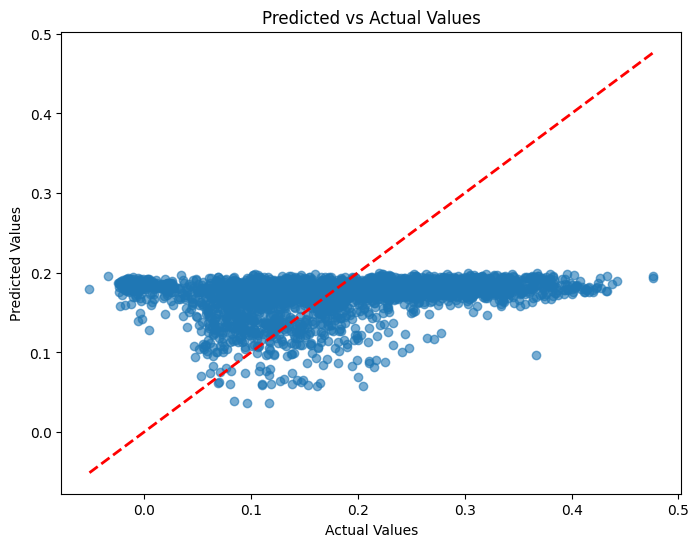

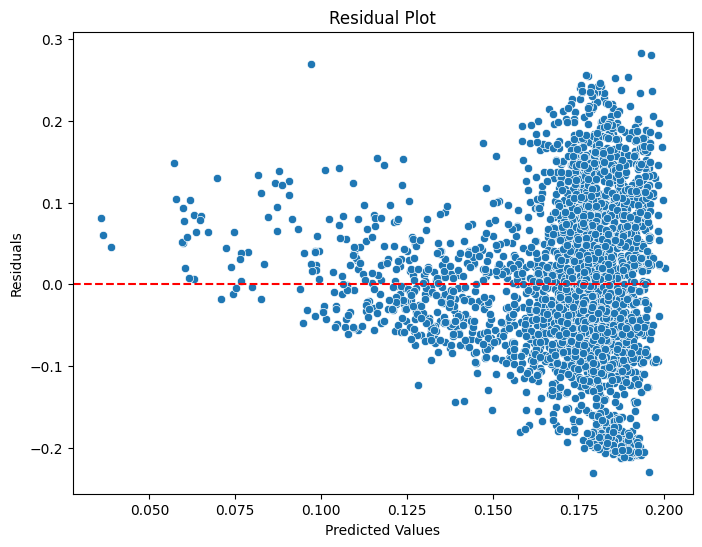

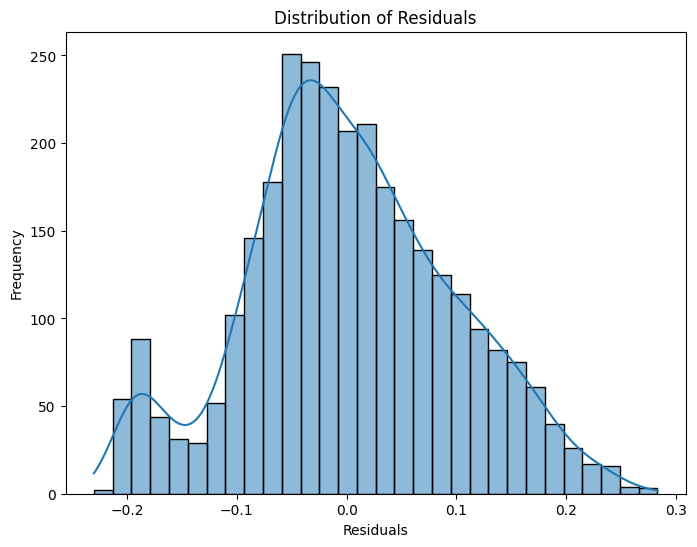

In [92]:
# Residuals
residuals = y_test - y_pred


# Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)  # Line of perfect prediction
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



### Results of Linear Regression

We dont see a good fit of the model.

We have a relatively lower MSE, but in context of NDVI, it needs to be interpreted carefullt
RMSE is also relatively low in terms of NDVI ranges
R^2 and adjusted R^2 are quite low which means that the model is not able to explain the variance of the predicted values

##### Graphs
*First Graph*
From the first graph we see that the model has not learnt well. The prediction are way off from the line

*Second graph*
There is also a higher variance in residuals

*Third graph*
Similar to previous graph, there is high variance in residuals, showing model is not too good


### Try the XGBoost Algorithm

In [93]:
from sklearn.ensemble import GradientBoostingRegressor

In [94]:
model = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)

In [95]:
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [96]:
y_pred = model.predict(X_test)

#### Accuracy assessment of XGBoost

Model Performance on Test Set:
Mean Squared Error (MSE): 0.0075
Root Mean Squared Error (RMSE): 0.0863
R^2 Score: 0.2200


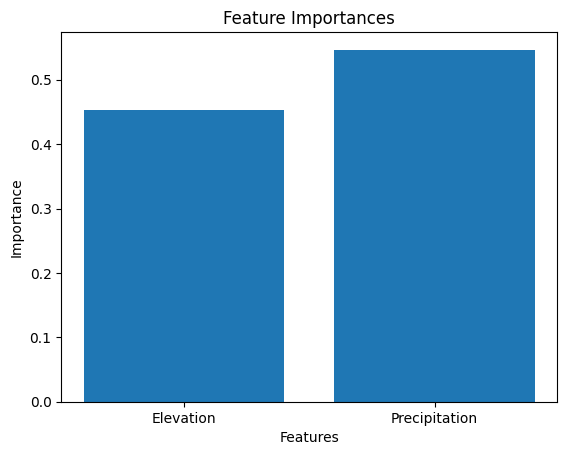

In [97]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = mse ** 0.5

# Display results
print("Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# Plot feature importances
plt.bar(X.columns, model.feature_importances_)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

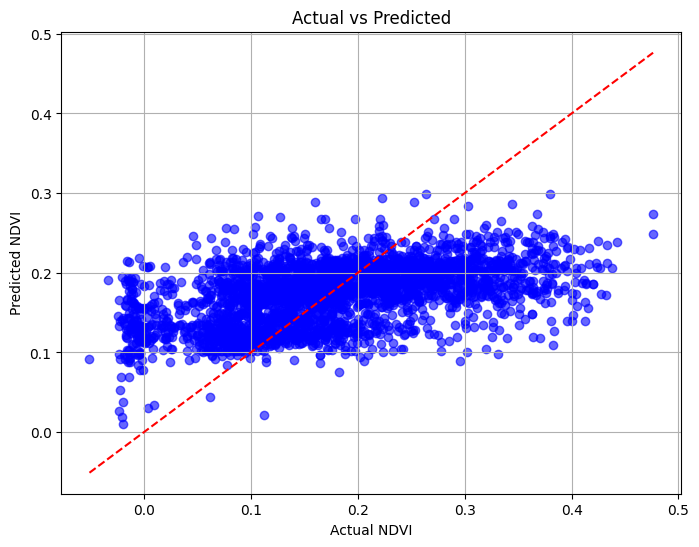

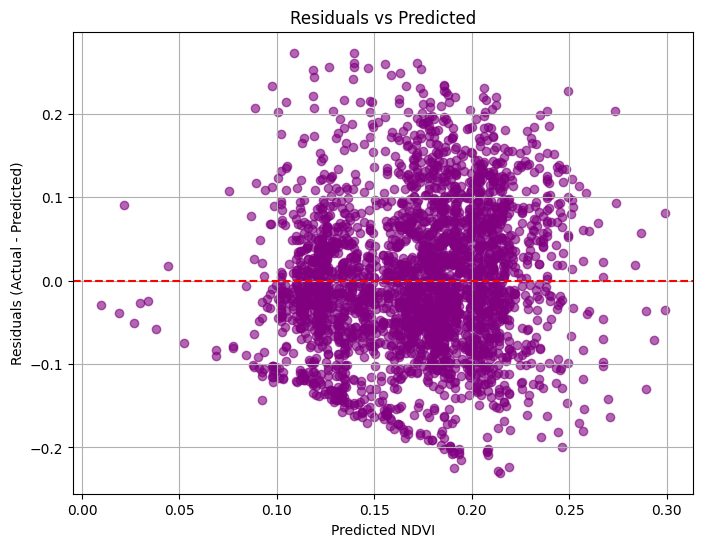

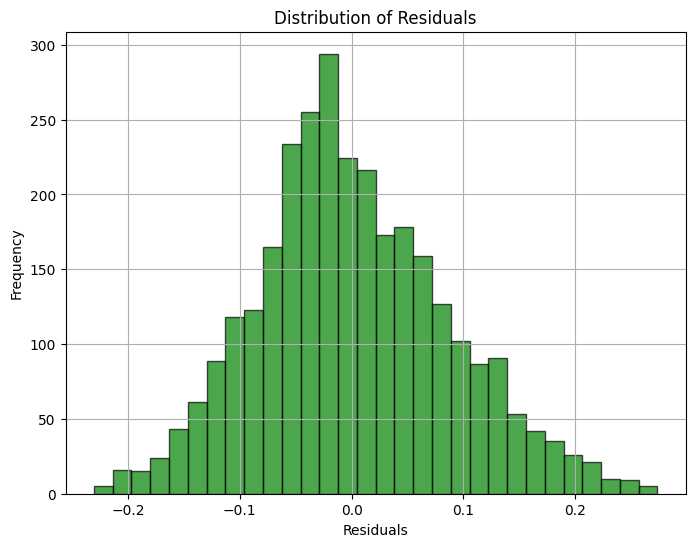

In [98]:
# Plotting Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual NDVI')
plt.ylabel('Predicted NDVI')
plt.grid(True)
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted NDVI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

# Distribution of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Results of XGBoost

We dont see a good fit of the model, however it improved from linear regression

We have a relatively lower MSE, but in context of NDVI, it needs to be interpreted carefullt
RMSE is also relatively low in terms of NDVI ranges
R^2 and adjusted R^2 are better which means that the model is able to explain the variance of the predicted values to some extent (better than linear regression)

##### Graphs
*First Graph*
From the first graph we see that the model has not learnt well. It is quite similar to linear regression

*Second graph*
There is also a higher variance in residuals

*Third graph*
Similar to previous graph, there is high variance in residuals, showing model is not too good, although better than linear regression

*Importance graph* Both have higher importance, almost half. Its because we only have these 2 as predictor variables


### Try tuning the parameters of XGBoost using grid search

In [99]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [100]:
# Define the model
model = GradientBoostingRegressor(random_state=42)

# Define hyperparameters grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

In [101]:
# Implement the grid search, it may take a minute or two to execute
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=1, verbose=2)

# Fit the model with cross-validation
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error', verbose=2)

In [102]:
# Select the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters from Grid Search: {best_params}")

Best Parameters from Grid Search: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}


In [103]:
# Train the best model
best_model = grid_search.best_estimator_

In [104]:
# Cross-validation on the entire dataset
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {np.mean(cv_scores)}")

Cross-Validation MSE: -0.006221574214679036


In [105]:
# Predictions on the test set
y_pred = best_model.predict(X_test)

#### Accuracy assessment of tuned XGBoost model

In [106]:
# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display results
print("Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Model Performance on Test Set:
Mean Squared Error (MSE): 0.0057
Root Mean Squared Error (RMSE): 0.0755
R^2 Score: 0.4033


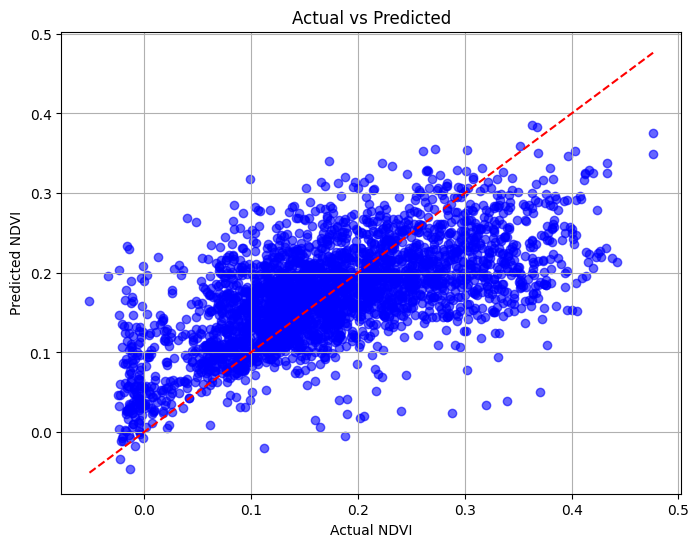

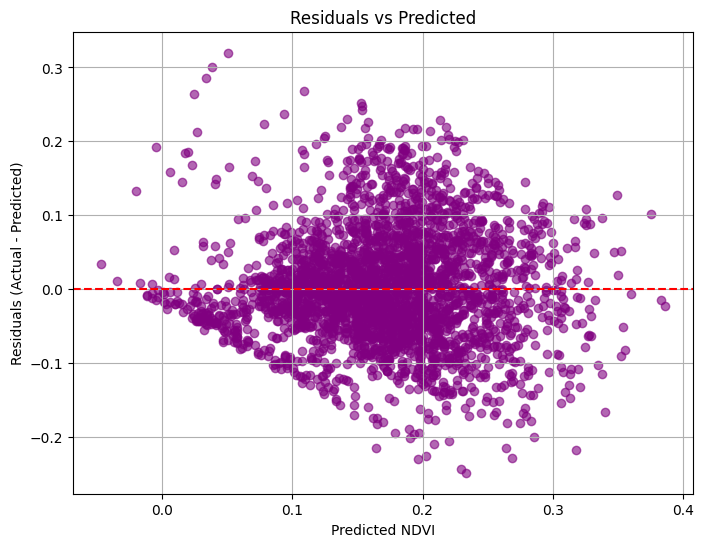

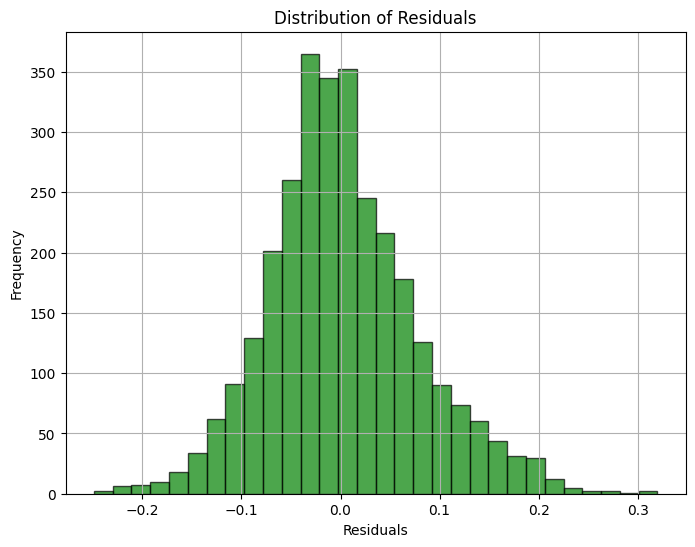

In [107]:
# Plotting Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual NDVI')
plt.ylabel('Predicted NDVI')
plt.grid(True)
plt.show()

# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted NDVI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

# Distribution of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

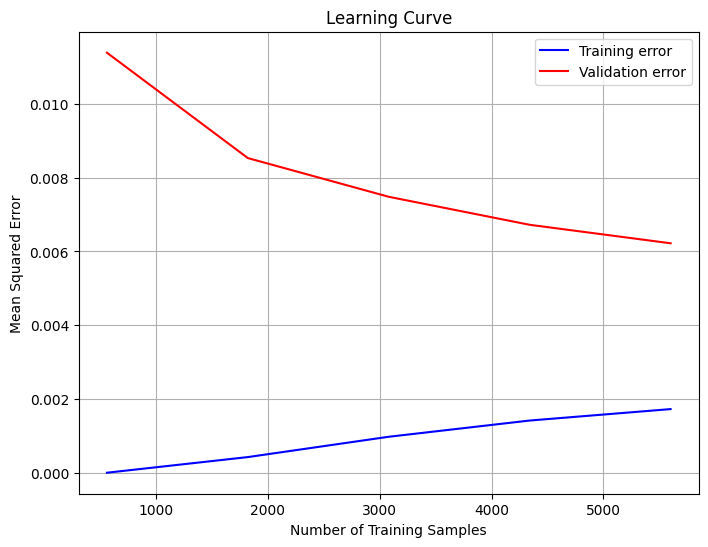

In [84]:
from sklearn.model_selection import learning_curve

# Learning Curve
train_sizes, train_scores, validation_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training error', color='blue')
plt.plot(train_sizes, -validation_scores.mean(axis=1), label='Validation error', color='red')
plt.title('Learning Curve')
plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

### Results of XGBoost tuned

We dont see a good fit of the model, however it improved from XGBoost and linear regression

We have a relatively lower MSE, but in context of NDVI, it needs to be interpreted carefully
RMSE is also relatively low in terms of NDVI ranges
R^2 and adjusted R^2 are moderate which means that the model is able to explain the variance of the predicted values to better extent (better than XGBoost(previous model) and linear regression)

##### Graphs
*First Graph*
From the first graph we see that the model has not learnt well. However, it is quite similar than linear regression

*Second graph*
There is also a higher variance in residuals, although less than linear regression

*Third graph*
There is high variance in residuals, showing model is not too good, although better than linear regression

#### Learning curve
Graph shows the learning curve of model and how the error rate varies with training samples. We see that the as we increase it, the training error increases but validation error decreases


### Overall results
Results from 3 models, Linear Regression, XGBoost (model 1), and XGBoost (Tuned) are not too good.
One reason is that we only have 2 predictor variables and it is not enough to capture the trends from which the model can learn well

### Dask implementation

In [108]:
import dask
import dask.dataframe as dd
from dask_ml.linear_model import LogisticRegression
from dask_ml.model_selection import train_test_split
import dask.array as da

from dask.distributed import Client

# Set up a Dask client (optional for local setup)
client = Client()

In [114]:
transposed_df_dask = transposed_df.copy()

In [115]:
transposed_df_dask

,Elevation,Precipitation,NDVI
0,326,82.767863,0.080727
1,951,70.541698,0.090735
2,418,68.638449,0.055195
3,396,44.584864,0.019005
4,286,70.480381,0.012560
...,...,...,...
9995,343,39.888167,0.190789
9996,325,36.903652,0.206287
9997,769,39.653263,0.072761
9998,539,57.807882,0.119465


In [122]:
# Convert DataFrame to Dask Array
X = da.from_array(transposed_df_dask[['Elevation', 'Precipitation']].values, chunks=(1000, 2))
y = da.from_array(transposed_df_dask['NDVI'].values, chunks=(1000,))


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [123]:
## I could not make this cell to run, on CRIB I keep getting an error for scikit-learn and cant install dask-ml on my local pc

# Create the model
model = LogisticRegression()

# Fit the model using Dask
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

2024-11-08 03:34:25,285 - distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/__check_build/__init__.py", line 48, in <module>
    from ._check_build import check_build  # noqa
ImportError: /usr/local/lib/python3.8/dist-packages/sklearn/__check_build/../../scikit_learn.libs/libgomp-d22c30c5.so.1.0.0: cannot allocate memory in static TLS block

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.8/site-packages/distributed/protocol/core.py", line 158, in loads
    return msgpack.loads(
  File "msgpack/_unpacker.pyx", line 194, in msgpack._cmsgpack.unpackb
  File "/home/jovyan/.local/lib/python3.8/site-packages/distributed/protocol/core.py", line 138, in _decode_default
    return merge_and_deserialize(
  File "/usr/lib/python3.8/contextlib.py", line 75, in inner
    return func(*args, **kwds)
  File

KeyboardInterrupt: 